## Yelp photo Classification with Transfer Learning. 

Note that the train, test and the valid dataset contains 5 classes: food, menu, outside, interior and drink. Here the train folder has 6000 images, the validation and test folder has 1000 images respectively. In this notebook we will use transfer learning to classify objects in the yelp dataset. 

In [4]:
# General Libs
import tensorflow as tf
import glob
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from pathlib import Path
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
train_path = '/content/drive/MyDrive/Datasets/train_dir'
test_path = '/content/drive/MyDrive/Datasets/test_dir'
valid_path = '/content/drive/MyDrive/Datasets/valid_dir'

In [7]:
train_folder = Path('/content/drive/MyDrive/Datasets/train_dir')
test_folder = Path(f'/content/drive/MyDrive/Datasets/test_dir')
valid_folder = Path('/content/drive/MyDrive/Datasets/valid_dir')

In [8]:
# Choose the hyperparameters
train_size = 6000
valid_size = 1000
test_size = 1000
img_height = 224
img_width = 224
n_classes = 5
batch_size = 32
n_epochs = 20

### Transfer Learning with VGG19

In [9]:
# Initiate the Data generator for VGG19
datagen = ImageDataGenerator(rescale=1.0 / 255, preprocessing_function=preprocess_input)

# Create batches of data from each set (train, test, validation)
train_ds = datagen.flow_from_directory(directory=train_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

valid_ds = datagen.flow_from_directory(directory=valid_folder,
                                               target_size=(img_height,
                                                            img_width),
                                               color_mode='rgb',
                                               class_mode='categorical',
                                               batch_size=batch_size)

test_ds = datagen.flow_from_directory(directory=test_folder,
                                              target_size=(img_height,
                                                           img_width),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size=batch_size,
                                              shuffle=False)

Found 6000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.


Check the label dictionary for the test dataset

In [10]:
print('Number of samples: ',test_ds.samples)
print('Number of classes: ',len(test_ds.class_indices))
print('Number of samples per class:', int(test_ds.samples/len(test_ds.class_indices)))

Number of samples:  1000
Number of classes:  5
Number of samples per class: 200


In [11]:
labels = {value: key for key, value in test_ds.class_indices.items()}

print("Label Mappings for classes present in the test dataset\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the test dataset

0 : drink
1 : food
2 : interior
3 : menu
4 : outside


Let's plot some images from the test generator

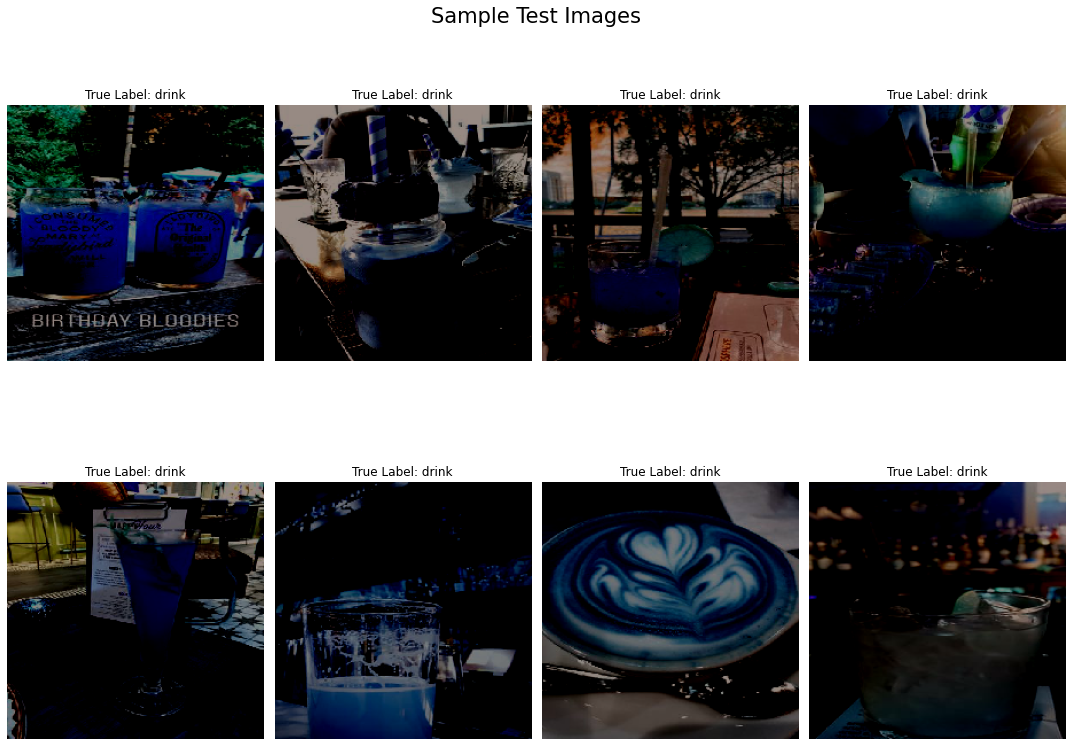

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(15, 12))
idx = 0

for i in range(2):
    for j in range(4):
        label = labels[np.argmax(test_ds[0][1][idx])]
        ax[i, j].set_title(f"True Label: {label}")
        ax[i, j].imshow(test_ds[0][0][idx][:, :, :])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Sample Test Images", fontsize=21)
plt.show()

### Load the VGG19 Model

We are going to use the VGG19 as a transfer learning framework, we will use the pre-trained ImageNet weights with this model.

In [13]:
#Import the pretrained VGG19 model
vgg_model = VGG19(weights='imagenet', include_top=False, input_shape=(224,224,3))
vgg_model.summary()

80134624/80134624 [==============================] - 2s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [14]:
x = Flatten()(vgg_model.output)
x=Dropout(0.3)(x)
x = Dense(100, activation='relu')(x)
x=Dropout(0.2)(x)
# final softmax layer with 5 categories
predictions = Dense(5, activation='softmax')(x)

# creating the full model:
full_model = Model(inputs=vgg_model.input, outputs=predictions)

In [15]:
# Freezing Convolutional layers
for layer in vgg_model.layers:
    layer.trainable = False

# Summarizing layers
full_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [16]:
opt = keras.optimizers.Adam(learning_rate=1e-5)
full_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy']) 

In [17]:
from tensorflow.keras.callbacks import EarlyStopping

es=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

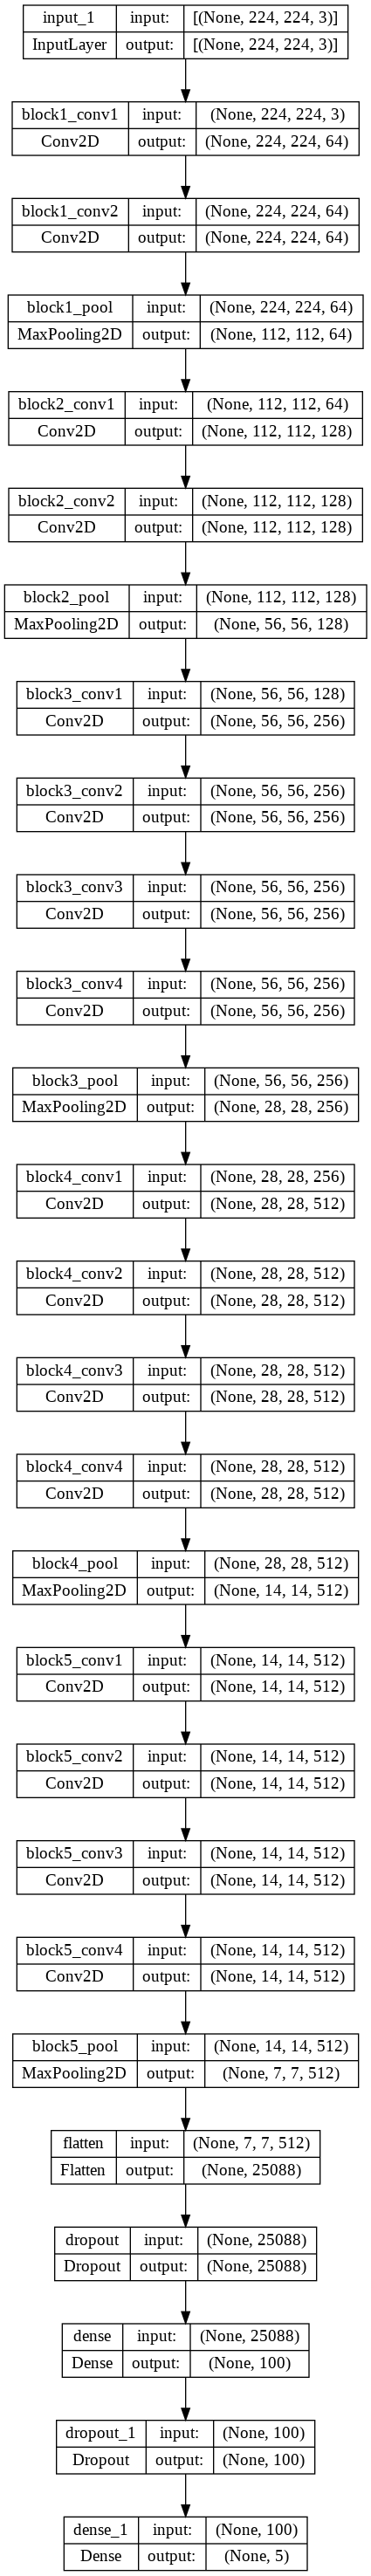

In [18]:
dot_img_file = 'model_1.png'
tf.keras.utils.plot_model(full_model, to_file=dot_img_file, show_shapes=True)

In [19]:
history = full_model.fit(train_ds,epochs=n_epochs,
                               validation_data=valid_ds,
                               steps_per_epoch=train_size / batch_size,
                               validation_steps=valid_size / batch_size, 
                               callbacks=[es])

Epoch 1/20
187/187 [==============================] - 2878s 15s/step - loss: 1.1590 - accuracy: 0.5285 - val_loss: 0.6686 - val_accuracy: 0.7530
Epoch 2/20
187/187 [==============================] - 53s 281ms/step - loss: 0.6919 - accuracy: 0.7295 - val_loss: 0.5336 - val_accuracy: 0.8040
Epoch 3/20
187/187 [==============================] - 51s 273ms/step - loss: 0.5854 - accuracy: 0.7722 - val_loss: 0.4858 - val_accuracy: 0.8250
Epoch 4/20
187/187 [==============================] - 52s 279ms/step - loss: 0.5185 - accuracy: 0.7990 - val_loss: 0.4527 - val_accuracy: 0.8430
Epoch 5/20
187/187 [==============================] - 53s 279ms/step - loss: 0.4706 - accuracy: 0.8195 - val_loss: 0.4400 - val_accuracy: 0.8350
Epoch 6/20
187/187 [==============================] - 51s 272ms/step - loss: 0.4386 - accuracy: 0.8390 - val_loss: 0.4242 - val_accuracy: 0.8440
Epoch 7/20
187/187 [==============================] - 51s 269ms/step - loss: 0.4033 - accuracy: 0.8558 - val_loss: 0.4117 - val_ac

In [20]:
from tensorflow.keras.models import load_model

full_model.save('/content/drive/MyDrive/Datasets/Models/VGG19.h5')

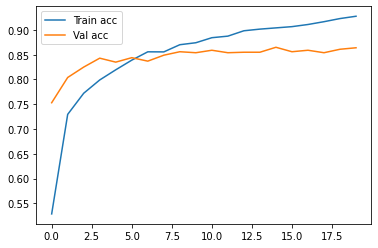

In [21]:
# accuracy
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='Val acc')
plt.legend()
plt.show()

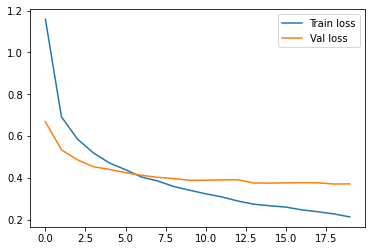

In [22]:
# loss
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.legend()
plt.show()

In [23]:
test_loss, test_accuracy = full_model.evaluate(test_ds)

32/32 [==============================] - 334s 11s/step - loss: 0.3514 - accuracy: 0.8640


In [24]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Test Loss:     0.3513692021369934
Test Accuracy: 0.8640000224113464


In [25]:
model = load_model('/content/drive/MyDrive/Datasets/Models/VGG19.h5')

In [26]:
preds = model.predict(test_ds, batch_size=batch_size)

y_pred=np.argmax(preds,axis=1)
y_true = test_ds.classes

32/32 [==============================] - 8s 234ms/step


In [27]:
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(test_ds.classes, y_pred)

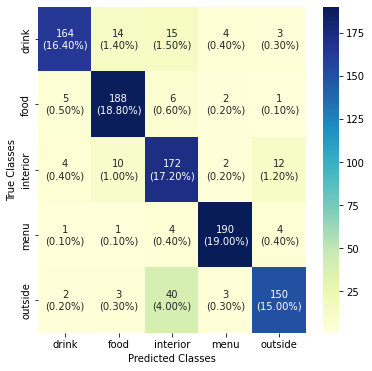

In [28]:
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
box_labels = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
box_labels = np.asarray(box_labels).reshape(5, 5)

plt.figure(figsize = (6, 6))
sns.heatmap(cm, xticklabels=labels.values(), yticklabels=labels.values(),
           cmap="YlGnBu", fmt="", annot=box_labels)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.show()

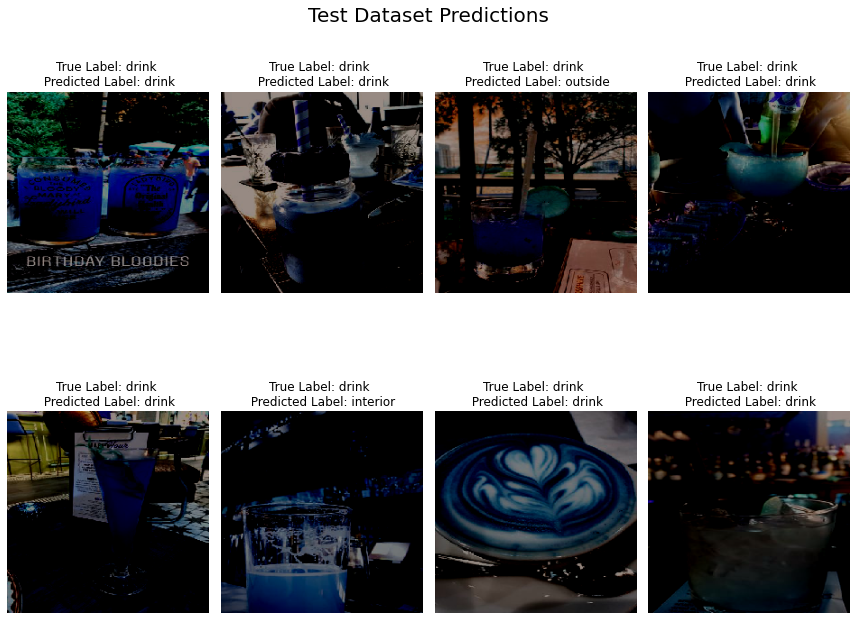

In [29]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(12, 10))
idx = 0

for i in range(2):
    for j in range(4):
        predicted_label = labels[np.argmax(preds[idx])]
        ax[i, j].set_title(f"True Label: {label} \n Predicted Label: {predicted_label}")
        ax[i, j].imshow(test_ds[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()